In [10]:
import torch
from torchvision import transforms as T
from lightly.transforms import SimCLRTransform, DINOTransform, MAETransform, MoCoV2Transform, utils
from datasets import create_dataset
from models import MAEModel
import pytorch_lightning as pl
import os
import copy
import gc
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
from pathlib import Path
from models import BYOLModel, SimCLRModel

In [14]:

import eval
import importlib
import models
from eval import *
importlib.reload(models)
importlib.reload(eval)

<module 'eval' from 'c:\\Users\\User\\Desktop\\studia\\Sem 6\\WB\\nowewb\\Warsztaty_Badawcze\\eval.py'>

# 1 model

In [15]:
config = Config()

result = evaluate_single(
    checkpoint_path="./checkpoints/cifar100/mae/ran-275/model_epoch_20.ckpt",
    method="mae",
    train_dataset="cifar100",
    test_dataset="cifar10",
    config=config
)

print(f"Linear Probing Accuracy: {result['linear_probing_accuracy']:.4f}")
print(f"Best k-NN Accuracy: {result['best_knn_accuracy']:.4f} (k={result['best_knn_k']})")
print("\nk-NN Results:")
for k, acc in result['knn_results'].items():
    print(f"  k={k}: {acc:.4f}")




Evaluating mae trained on cifar100, testing on cifar10
Checkpoint: ./checkpoints/cifar100/mae/ran-275/model_epoch_20.ckpt
Loading mae model: {'train_dataset': 'cifar100', 'method': 'mae', 'version': 'ran-275', 'filename': 'model_epoch_20.ckpt', 'pretrained': False, 'lr': 0.01, 'hyperparam': 0.75}


Extracting features: 100%|██████████| 40/40 [00:19<00:00,  2.06it/s]
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | Sequential         | 11.2 M | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | train_metric | MulticlassAccuracy | 0      | train
3 | val_metric   | MulticlassAccuracy | 0      | train
4 | test_metric  | MulticlassAccuracy | 0      | train
------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
7         Modules in train mode


Epoch 0: 100%|██████████| 196/196 [00:56<00:00,  3.45it/s, v_num=3, train_loss=1.570, val_loss=1.590, val_acc=0.407, train_acc=0.283]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s, v_num=3, train_loss=1.570, val_loss=1.590, val_acc=0.407, train_acc=0.283]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | Sequential         | 11.2 M | train
1 | criterion    | CrossEntropyLoss   | 0      | train
2 | train_metric | MulticlassAccuracy | 0      | train
3 | val_metric   | MulticlassAccuracy | 0      | train
4 | test_metric  | MulticlassAccuracy | 0      | train
------------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
7         Modules in train mode
67        Modules in eval mode


Epoch 0: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s, v_num=4, train_loss=2.310, val_loss=2.300, val_acc=0.100, train_acc=0.0986]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s, v_num=4, train_loss=2.310, val_loss=2.300, val_acc=0.100, train_acc=0.0986]
Linear Probing Accuracy: 0.1002
Best k-NN Accuracy: 0.1014 (k=50)

k-NN Results:
  k=5: 0.1005
  k=10: 0.1004
  k=20: 0.1004
  k=50: 0.1014


# porównanie hiperparametrów per model


Evaluating mae trained on cifar100, testing on cifar10
Checkpoint: ./checkpoints/cifar100/mae/ran-290/model_epoch_20.ckpt
Loading mae model: {'train_dataset': 'cifar100', 'method': 'mae', 'version': 'ran-290', 'filename': 'model_epoch_20.ckpt', 'pretrained': False, 'lr': 0.01, 'hyperparam': 0.9}


Extracting features: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]



Evaluating mae trained on cifar100, testing on cifar10
Checkpoint: ./checkpoints/cifar100/mae/pre-290/model_epoch_20.ckpt
Loading mae model: {'train_dataset': 'cifar100', 'method': 'mae', 'version': 'pre-290', 'filename': 'model_epoch_20.ckpt', 'pretrained': True, 'lr': 0.01, 'hyperparam': 0.9}


Extracting features: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


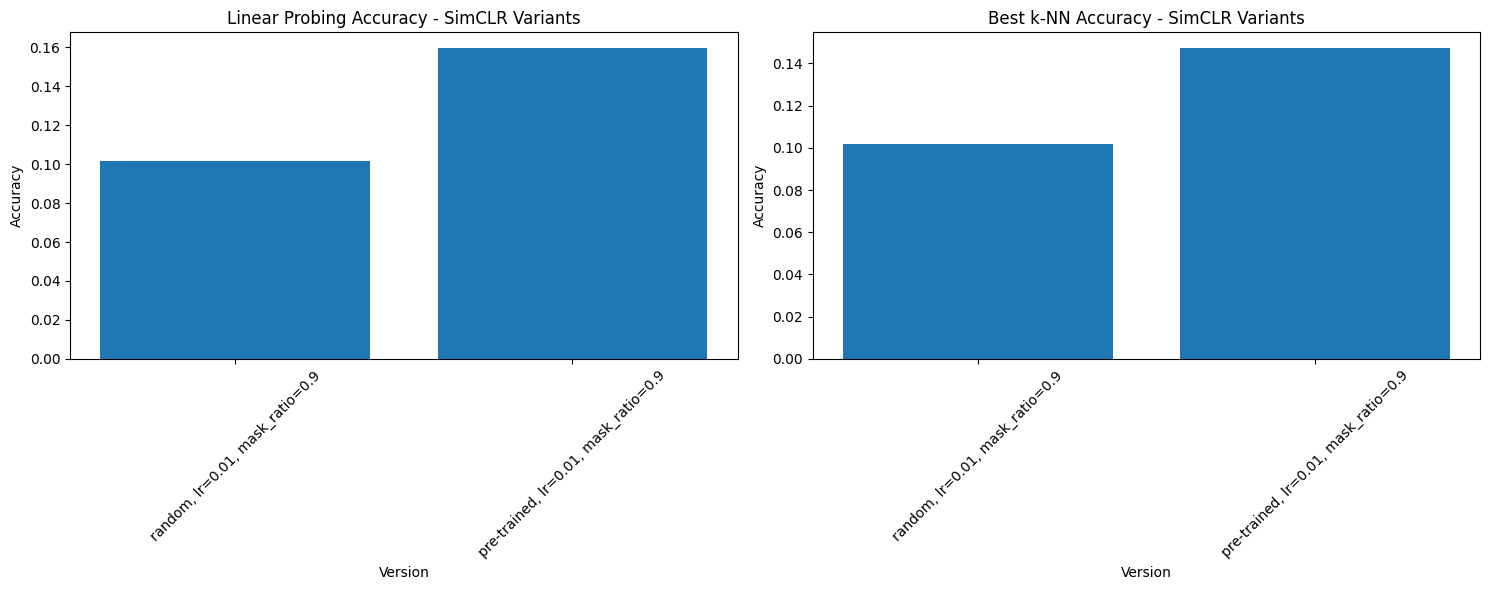

In [4]:

evaluator = SSLEvaluator(config)
results = []

# Lista ścieżek do różnych wersji SimCLR
mae_versions = [
    ("./checkpoints/cifar100/mae/ran-290/model_epoch_20.ckpt", "random, lr=0.01, mask_ratio=0.9"),
    ("./checkpoints/cifar100/mae/pre-290/model_epoch_20.ckpt", "pre-trained, lr=0.01, mask_ratio=0.9"),

]

for checkpoint_path, version_name in mae_versions:
    result = evaluator.evaluate_single_model(
        checkpoint_path=checkpoint_path,
        method="mae",
        train_dataset="cifar100",
        test_dataset="cifar10",
        hyperparameter_info=version_name
    )
    results.append(result)

# Wizualizacja porównania
df_comparison = pd.DataFrame(results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linear probing
ax1.bar(df_comparison['hyperparameters'], df_comparison['linear_probing_accuracy'])
ax1.set_title('Linear Probing Accuracy - SimCLR Variants')
ax1.set_xlabel('Version')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# k-NN
ax2.bar(df_comparison['hyperparameters'], df_comparison['best_knn_accuracy'])
ax2.set_title('Best k-NN Accuracy - SimCLR Variants')
ax2.set_xlabel('Version')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# WSSZYTSKIE

In [193]:

results_df = run_complete_evaluation(config)

# Wyświetl podsumowanie
print("=== EVALUATION SUMMARY ===")
print(f"Total models evaluated: {len(results_df)}")
print(f"\nTop 5 models (Linear Probing):")
print(results_df.nlargest(5, 'linear_probing_accuracy')[
    ['method', 'train_dataset', 'test_dataset', 'linear_probing_accuracy']
])

print(f"\nTop 5 models (k-NN):")
print(results_df.nlargest(5, 'best_knn_accuracy')[
    ['method', 'train_dataset', 'test_dataset', 'best_knn_accuracy', 'best_knn_k']
])



Evaluating mae trained on cifar100, testing on cifar10
Checkpoint: ./checkpoints\cifar100\mae\pre-275\model_epoch_10.ckpt
Loading mae model: {'train_dataset': 'cifar100', 'method': 'mae', 'version': 'pre-275', 'filename': 'model_epoch_10.ckpt', 'pretrained': True, 'lr': 0.01, 'hyperparam': 0.75}


Extracting features: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]



Evaluating mae trained on cifar100, testing on cifar100
Checkpoint: ./checkpoints\cifar100\mae\pre-275\model_epoch_10.ckpt
Loading mae model: {'train_dataset': 'cifar100', 'method': 'mae', 'version': 'pre-275', 'filename': 'model_epoch_10.ckpt', 'pretrained': True, 'lr': 0.01, 'hyperparam': 0.75}


Extracting features:   0%|          | 0/196 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [5]:

method_stats = results_df.groupby('method').agg({
    'linear_probing_accuracy': ['mean', 'std', 'max'],
    'best_knn_accuracy': ['mean', 'std', 'max']
}).round(4)

print("=== Performance by Method ===")
print(method_stats)

# Wizualizacja
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Box plot dla linear probing
results_df.boxplot(column='linear_probing_accuracy', by='method', ax=axes[0,0])
axes[0,0].set_title('Linear Probing Accuracy by Method')

# Box plot dla k-NN
results_df.boxplot(column='best_knn_accuracy', by='method', ax=axes[0,1])
axes[0,1].set_title('k-NN Accuracy by Method')

# Heatmap dla różnych wartości k
knn_data = []
for _, row in results_df.iterrows():
    if 'knn_results' in row and row['knn_results']:
        for k, acc in row['knn_results'].items():
            knn_data.append({
                'method': row['method'],
                'k': k,
                'accuracy': acc
            })

knn_df = pd.DataFrame(knn_data)
knn_pivot = knn_df.pivot_table(values='accuracy', index='method', columns='k', aggfunc='mean')
sns.heatmap(knn_pivot, annot=True, fmt='.3f', ax=axes[1,0], cmap='viridis')
axes[1,0].set_title('Average k-NN Accuracy Heatmap')

# Scatter plot: train vs test dataset performance
for method in results_df['method'].unique():
    method_data = results_df[results_df['method'] == method]
    axes[1,1].scatter(method_data['train_dataset'], 
                      method_data['linear_probing_accuracy'],
                      label=method, s=100, alpha=0.7)
axes[1,1].set_xlabel('Training Dataset')
axes[1,1].set_ylabel('Linear Probing Accuracy')
axes[1,1].set_title('Performance by Training Dataset')
axes[1,1].legend()

plt.tight_layout()
plt.show()



NameError: name 'results_df' is not defined

# CROSS-DATASET PERFORMANCE

In [6]:

cross_dataset = results_df.pivot_table(
    values='linear_probing_accuracy',
    index=['method', 'train_dataset'],
    columns='test_dataset',
    aggfunc='mean'
)

print("=== Cross-Dataset Performance Matrix ===")
print(cross_dataset)

# Wizualizacja
plt.figure(figsize=(10, 8))
sns.heatmap(cross_dataset, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0.5, vmax=1.0, center=0.75)
plt.title('Cross-Dataset Performance Heatmap\n(Train Dataset → Test Dataset)')
plt.tight_layout()
plt.show()



NameError: name 'results_df' is not defined

# EKSPORT

In [ ]:

results_df.to_csv('detailed_evaluation_results.csv', index=False)
results_df.to_excel('detailed_evaluation_results.xlsx', index=False)

# Stwórz raport tekstowy
with open('evaluation_summary.txt', 'w') as f:
    f.write("SSL Model Evaluation Summary\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("Best Overall Model:\n")
    best_model = results_df.loc[results_df['linear_probing_accuracy'].idxmax()]
    f.write(f"  Method: {best_model['method']}\n")
    f.write(f"  Training Dataset: {best_model['train_dataset']}\n")
    f.write(f"  Test Dataset: {best_model['test_dataset']}\n")
    f.write(f"  Linear Probing Accuracy: {best_model['linear_probing_accuracy']:.4f}\n")
    f.write(f"  Best k-NN Accuracy: {best_model['best_knn_accuracy']:.4f}\n\n")
    
    f.write("Method Rankings (Average Linear Probing Accuracy):\n")
    method_ranking = results_df.groupby('method')['linear_probing_accuracy'].mean().sort_values(ascending=False)